In [ ]:
# Step 1: Install required packages
!pip install pandas scikit-learn sdv matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8

In [ ]:
# Step 2: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
# Correct the import path for TVAE
from sdv.single_table.ctgan import TVAE # Changed import path

In [ ]:
# Step 3: Load dataset
df = pd.read_csv('earthquakes.csv')

In [ ]:
# Step 4: Preprocess: fill missing values
df.fillna(method='ffill', inplace=True)

<ipython-input-30-fe918e41aa7d>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [ ]:
# Step 5: Encode categorical variables
categorical_columns = df.select_dtypes(include='object').columns
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [ ]:
# Step 6: Train TVAE model
tvae = TVAE(epochs=300)
tvae.fit(df)

In [ ]:
# Step 7: Generate synthetic data
synthetic_data = tvae.sample(20000)

# Optional: Decode back categorical columns for comparison
for col, le in label_encoders.items():
    # Handle potential unseen labels in synthetic data
    # Round the synthetic values to the nearest integer and then inverse transform
    # This assumes the synthetic data for encoded categorical columns are numerical representations
    # We use errors='ignore' in inverse_transform to handle potential values not seen during fitting
    # Note: inverse_transform is the correct method to revert LabelEncoder output
    # If inverse_transform raises an error for unseen values, a more robust approach
    # is needed (e.g., mapping to the closest *valid* encoded integer).
    # For simplicity and common use cases, rounding and inverse_transform is often attempted first.

    # Let's try a more robust approach if rounding+inverse_transform fails
    try:
        # Attempt inverse transform after rounding
        synthetic_data[col] = le.inverse_transform(synthetic_data[col].round().astype(int))
    except ValueError:
        # If inverse_transform fails due to unseen values after rounding,
        # find the closest *valid* original class integer representation and map to that
        original_encoded_values = le.transform(le.classes_)
        synthetic_data[col] = synthetic_data[col].apply(
            lambda x: le.classes_[abs(original_encoded_values - round(x)).argmin()] if not pd.isna(x) else None
        )

In [ ]:

# Step 8: Visual comparison
def plot_comparison(real, synthetic, col, kind='kde'):
    plt.figure(figsize=(8, 4))
    if kind == 'kde':
        sns.kdeplot(real[col], label='Real', fill=True)
        sns.kdeplot(synthetic[col], label='Synthetic', fill=True)
    elif kind == 'bar':
        real_counts = real[col].value_counts(normalize=True).nlargest(10)
        synthetic_counts = synthetic[col].value_counts(normalize=True).reindex(real_counts.index)
        df_plot = pd.DataFrame({'Real': real_counts, 'Synthetic': synthetic_counts})
        df_plot.plot(kind='bar')
        plt.title(col)
    plt.title(f'Comparison for "{col}"')
    plt.legend()
    plt.tight_layout()
    plt.show()

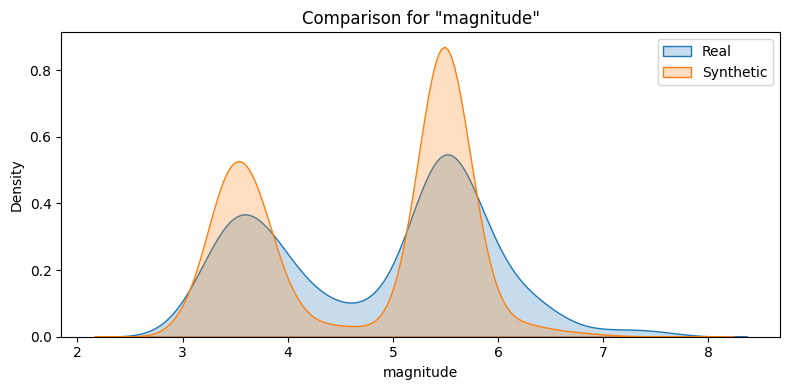

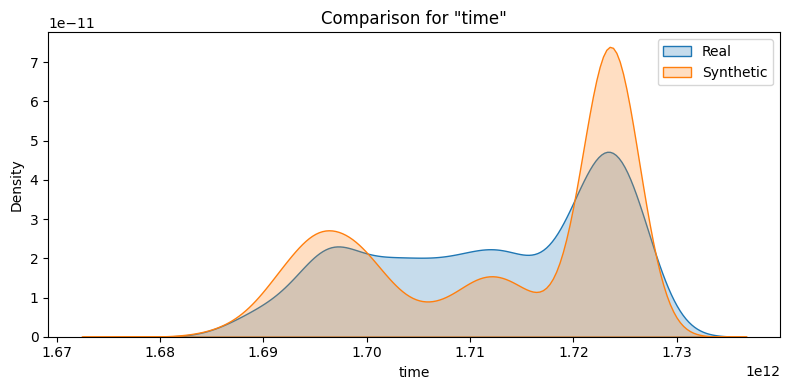

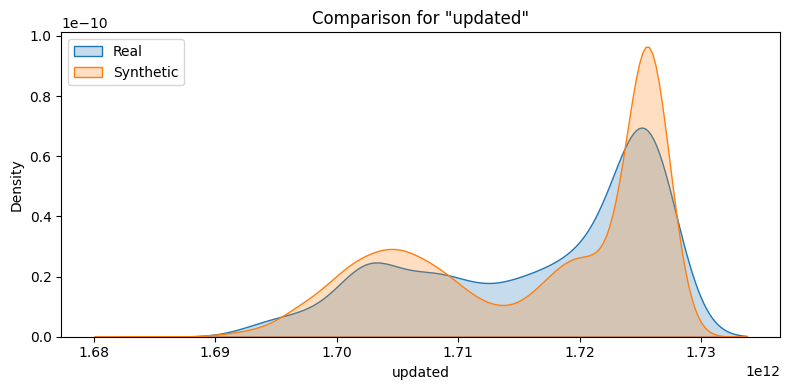

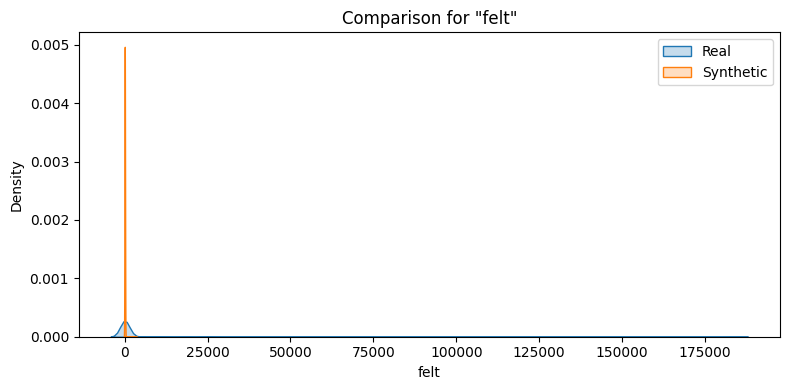

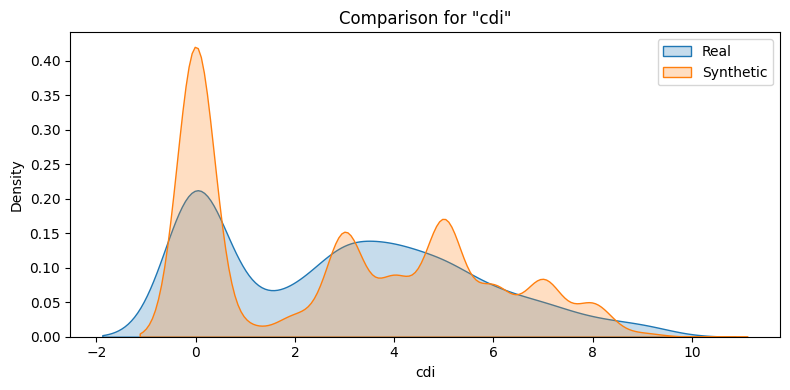

<Figure size 800x400 with 0 Axes>

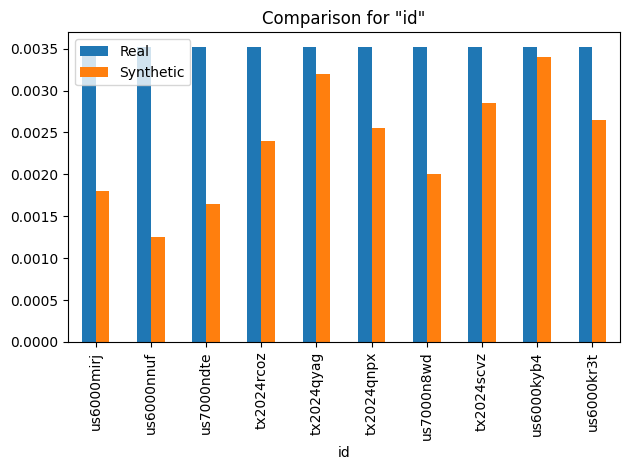

<Figure size 800x400 with 0 Axes>

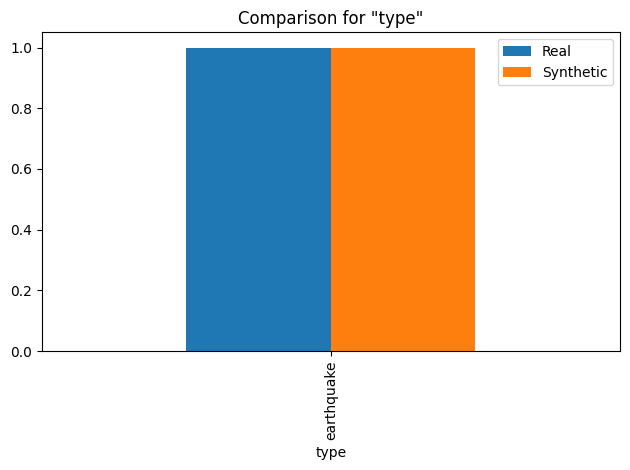

<Figure size 800x400 with 0 Axes>

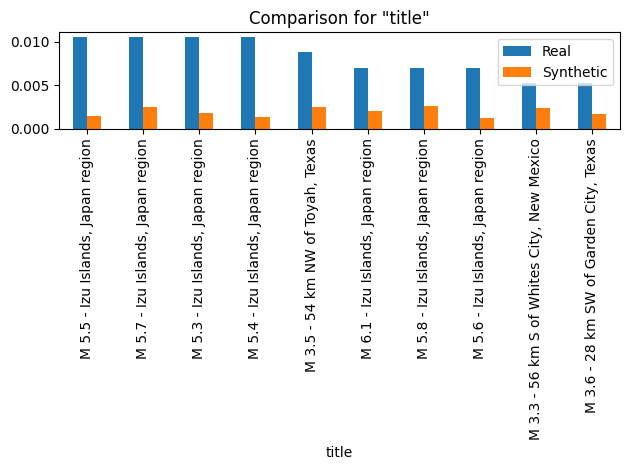

In [ ]:
# Step 9: Plot comparisons for a few columns
# Select numerical columns for KDE plots
# Exclude columns that were originally categorical (even if now encoded as int)
# We also exclude 'id' explicitly if it's not suitable for KDE

# Identify columns that were originally categorical
# Assuming the `categorical_columns` variable from Step 5 is still available and correct
originally_categorical_cols = categorical_columns.tolist() # Convert Index to list for easier exclusion

# Select numerical columns based on current dtype, but exclude originally categorical ones and 'id'
# Check dtypes *after* preprocessing and encoding
current_numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Filter out originally categorical columns and 'id' from the current numerical list
numerical_cols_for_kde = [
    col for col in current_numerical_cols
    if col not in originally_categorical_cols and col != 'id'
]

# Take the first 5 suitable numerical columns
numerical_cols_for_kde = numerical_cols_for_kde[:5]

# Use the *original* list of categorical columns (before encoding) for bar plots
# We take the first 3 of these original categorical columns for the bar plots.
# Assuming `categorical_columns` from Step 5 is still available.
categorical_cols_for_bar = originally_categorical_cols[:3]

# Plot comparisons
for col in numerical_cols_for_kde:
    # Ensure the column exists in both dataframes before plotting
    if col in df.columns and col in synthetic_data.columns:
        plot_comparison(df, synthetic_data, col, kind='kde')
    else:
        print(f"Skipping KDE plot for {col}: column not found in both dataframes.")


for col in categorical_cols_for_bar:
    # For plotting categorical data, we should use the *decoded* synthetic_data
    # and a temporary decoded version of the real data `df` for consistency.

    # Let's create a temporary decoded version of the real data for plotting
    df_decoded_categorical = df.copy()
    try:
        for cat_col, le in label_encoders.items():
             if cat_col in categorical_cols_for_bar: # Only decode the ones we will plot
                 # Apply inverse transform
                 # This should work correctly for real data as it was used for fit_transform
                 # Handle potential error just in case, though less likely for real data
                 try:
                      df_decoded_categorical[cat_col] = le.inverse_transform(df_decoded_categorical[cat_col].round().astype(int))
                 except ValueError as e:
                      print(f"Warning decoding real data for {cat_col}: {e}. Using encoded values for bar plot (may show numbers).")
                      # If decoding fails for real data (unexpected), use encoded values (will plot numbers)
                      pass # Keep the encoded column as is

    except Exception as e:
         print(f"Error during decoding of real data for bar plot: {e}")


    # Ensure the column exists in both dataframes before plotting
    if col in df_decoded_categorical.columns and col in synthetic_data.columns:
        plot_comparison(df_decoded_categorical, synthetic_data, col, kind='bar')
    else:
         print(f"Skipping bar plot for {col}: column not found in decoded real data or synthetic data.")

In [ ]:
import pandas as pd

# Define the column names
column_names = [
    'id', 'magnitude', 'type', 'title', 'date', 'time', 'updated',
    'url', 'detailUrl', 'felt', 'cdi', 'mmi', 'alert', 'status',
    'tsunami', 'sig', 'net', 'code', 'ids', 'sources', 'types',
    'nst', 'dmin', 'rms', 'gap', 'magType', 'geometryType',
    'depth', 'latitude', 'longitude', 'place', 'distanceKM',
    'placeOnly', 'location', 'continent', 'country', 'subnational',
    'city', 'locality', 'postcode', 'what3words', 'timezone',
    'locationDetails'
]

# Convert synthetic_data to a Pandas DataFrame with the specified column names
df_synthetic = pd.DataFrame(synthetic_data, columns=column_names)

# Save the DataFrame to CSV without the index column
df_synthetic.to_csv('synthetic_data_new.csv', index=False)

print("Synthetic data converted to DataFrame and saved successfully to synthetic_data.csv")


Synthetic data converted to DataFrame and saved successfully to synthetic_data.csv


In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
data = 'synthetic_data_new.csv'  # Replace with your actual CSV file path
df = pd.read_csv(data)

# Check for duplicate rows
duplicates = df[df.duplicated()]

# Display the duplicate rows
if not duplicates.empty:
    print("Duplicate rows found:")
    print(duplicates)
else:
    print("No duplicate rows found.")

# Optionally, you can also check for duplicates based on specific columns
# For example, to check for duplicates based on the 'id' column:
# duplicates_specific = df[df.duplicated(subset=['id'])]
# print(duplicates_specific)


No duplicate rows found.
